In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import copy
%matplotlib notebook

In [2]:
from neurodiffeq import diff      # the differentiation operation
from neurodiffeq.ode import solve # the ANN-based solver
from neurodiffeq.conditions import IVP   # the initial condition
from neurodiffeq.networks import FCNN    # fully-connect neural network
from neurodiffeq.networks import SinActv # sin activation
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
from neurodiffeq.callbacks import MonitorCallback
from neurodiffeq.callbacks import WeightCallback,WeightCallback1
from neurodiffeq.callbacks import SolutionCallback
from neurodiffeq.callbacks import PeriodLocal
from scipy.stats import norm

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:


DIFFEQS_TRAIN = {
'exp1':lambda u,t: [diff(u, t) + u],
'exp12':lambda u,t: [diff(u, t) - u],
'tanh1': lambda u,t:[diff(u, t) + u**2 -1],
'psig1':lambda u,t: [diff(u, t) -3*u +u**2],
'r11': lambda u,t:[diff(u, t) -u +u**2 +u**3],
'r12': lambda u,t:[diff(u, t) +u +u**2],
'r13': lambda u,t:[diff(u, t) +u**2],
'r14': lambda u,t:[diff(u, t) -u**2],
'sigmoid0': lambda u,t:[diff(u, t) -u + u**2],
'sigmoid1': lambda u,t:[diff(u, t) -u + u**2],
'sigmoid12': lambda u,t:[diff(u, t) -u +u**2],
}

MAX_EPOCHS = 3000
BURNIN = 0
SUB_RATE = 1
eps = np.arange(1,1+MAX_EPOCHS,dtype=int)[BURNIN::SUB_RATE]
INIT_VAL = [IVP(t_0=0.0, u_0=0.5)]
T_MIN = 0.0
T_MAX=2.0
T_EVAL = torch.linspace(T_MIN,T_MAX,100)
T_EVAL1 = torch.linspace(0.7,T_MAX,1)


for system_name,system in DIFFEQS_TRAIN.items():
    # solver changes NETS in place so we re-initialize every time we run this
    NETS = [
    FCNN(n_input_units=1, n_output_units=1, hidden_units=[5])
    ]
    #call the weights
    cb = PeriodLocal(period=SUB_RATE)
    wcb = WeightCallback(system_name,T_EVAL)
    cb.set_action_callback(wcb)
    #call the weights
    cb0 = PeriodLocal(period=SUB_RATE)
    wcb0 = WeightCallback1(system_name,T_EVAL1)
    cb0.set_action_callback(wcb0)
    #call the solutions
    cb1 = PeriodLocal(period=SUB_RATE)
    wcb1 = SolutionCallback(system_name,T_EVAL)
    cb1.set_action_callback(wcb1)

    solver = Solver1D(
        ode_system=system,
        conditions=INIT_VAL,
        t_min=T_MIN,
        t_max=T_MAX,
        nets = NETS
    )
    solver.fit(max_epochs=MAX_EPOCHS,callbacks=[cb,cb0,cb1])
    
    



In [31]:
# MAX_EPOCHS = 3000
BURNIN = 1
equations = list(DIFFEQS_TRAIN.keys())
import os
%matplotlib inline
eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]

Text(0.5, 1.0, 'Epoch 2999 Weight Distribution')

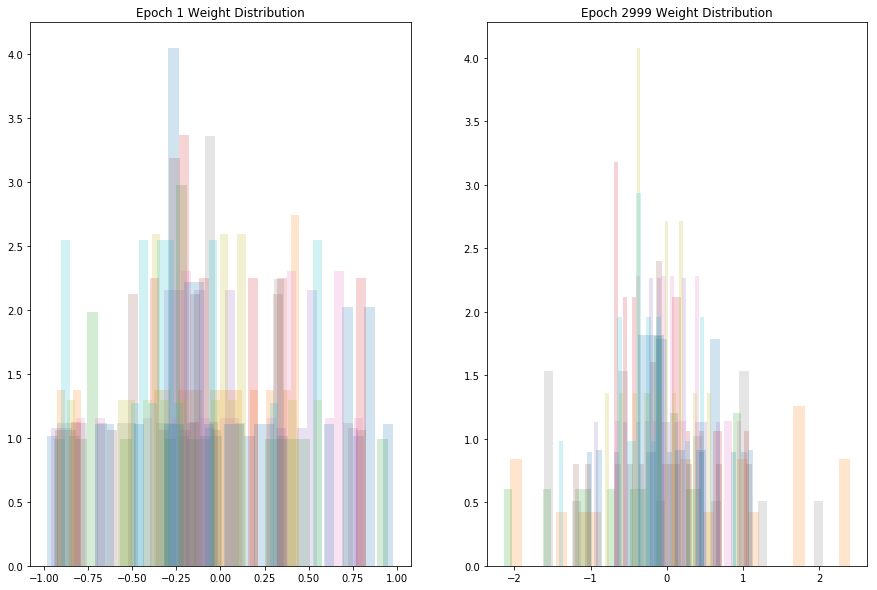

In [32]:
fig,ax = plt.subplots(1,2,figsize=(15,10))

ep= 1

for method in equations:
    param_a = np.load(f'data/{method}_1/{ep}.npy')
    ax[0].hist(param_a,density=True,label=method,bins=30,alpha=.2)

ax[0].set_title('Epoch 1 Weight Distribution')

ep= 2999

for method in equations:
    param_a = np.load(f'data/{method}_1/{ep}.npy')
    ax[1].hist(param_a,density=True,label=method,bins=30,alpha=.2)
ax[1].set_title('Epoch 2999 Weight Distribution')


#### weight cosine similarity

In [33]:
dydw= np.zeros((len(eps),len(equations)))
wdots= np.zeros((len(eps),len(equations)))
sols = np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}_w/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_w/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))

        param_a = np.load(f'data/{equations[meth_dex]}_solution/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_solution/{ep}.npy')
        sols[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))

        param_a = np.load(f'data/{equations[meth_dex]}_dydw/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_dydw/{ep}.npy')
        dydw[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))


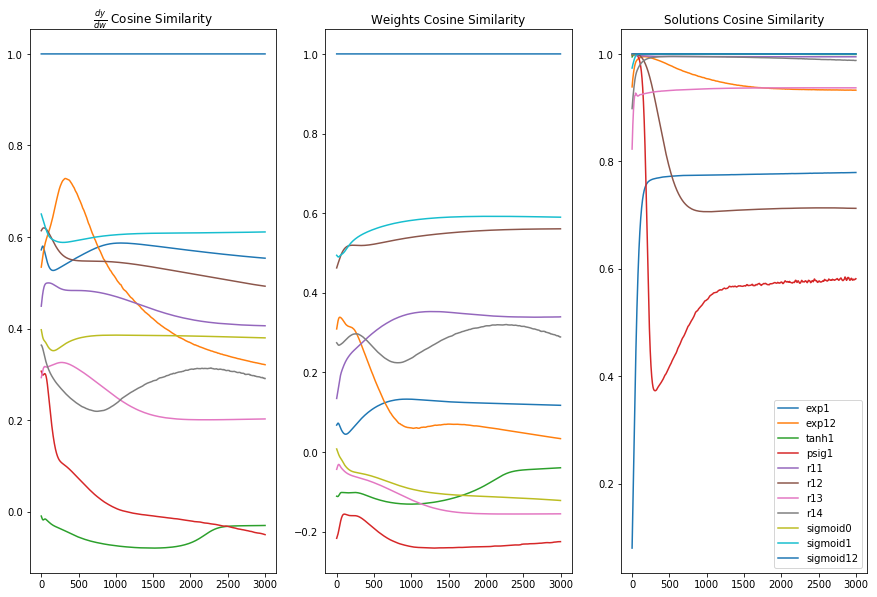

In [34]:

fig,ax = plt.subplots(1,3,figsize=(15,10))
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
for i in range(len(equations)):
    ax[0].plot(eps,dydw[:,i],label=equations[i])
    ax[1].plot(eps,wdots[:,i],label=equations[i])
    ax[2].plot(eps,sols[:,i],label=equations[i])
ax[0].set_title(r'$\frac{dy}{dw}$ Cosine Similarity')
ax[1].set_title('Weights Cosine Similarity')
ax[2].set_title('Solutions Cosine Similarity')
plt.legend()

##### Ranked Weights

In [35]:
dydw= np.zeros((len(eps),len(equations)))
wdots= np.zeros((len(eps),len(equations)))
sols = np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        param_a = np.load(f'data/{equations[meth_dex]}_1/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_1/{ep}.npy')
        wdots[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))

        param_a = np.load(f'data/{equations[meth_dex]}_solution/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_solution/{ep}.npy')
        sols[ep_index,meth_dex]=np.dot(param_a,param_b)/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))

        param_a = np.load(f'data/{equations[meth_dex]}_dydw/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_dydw/{ep}.npy')
        dydw[ep_index,meth_dex]=np.dot(np.sort(param_a),np.sort(param_b))/(np.linalg.norm(param_a,ord=2)*np.linalg.norm(param_b,ord=2))


(0.99, 1)

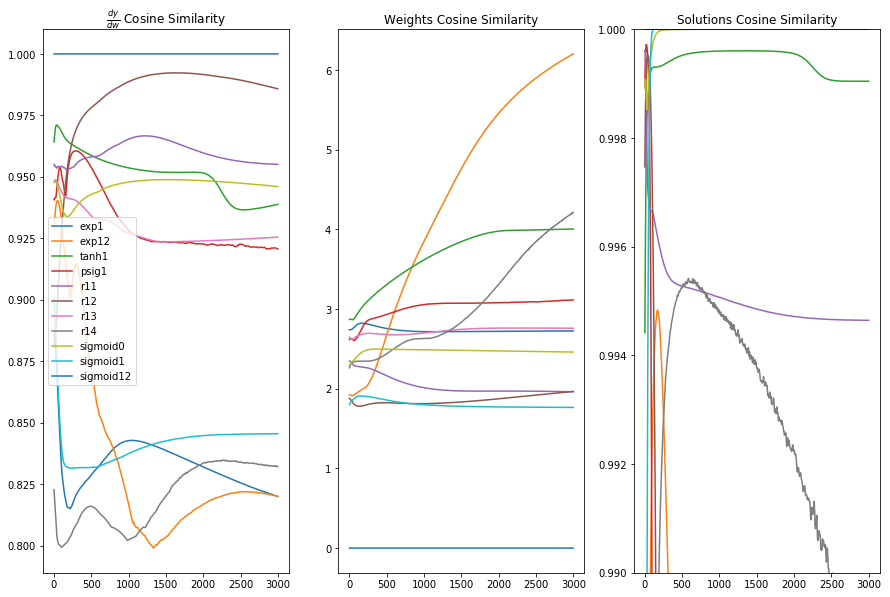

In [39]:


eps = [i for i in range(BURNIN,MAX_EPOCHS) if (i%SUB_RATE==0)]
fig,ax = plt.subplots(1,3,figsize=(15,10))
# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
for i in range(len(equations)):
    ax[0].plot(eps,dydw[:,i],label=equations[i])
    ax[1].plot(eps,wdots[:,i],label=equations[i])
    ax[2].plot(eps,sols[:,i],label=equations[i])
ax[0].set_title(r'$\frac{dy}{dw}$ Cosine Similarity')
ax[1].set_title('Weights Cosine Similarity')
ax[2].set_title('Solutions Cosine Similarity')
ax[0].legend()
ax[2].set_ylim([0.99,1])

### abs diff

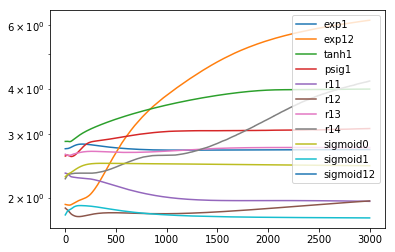

In [38]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}_1/{ep}.npy')
#         print(param_a)
        param_b = np.load(f'data/{equations[-1]}_1/{ep}.npy')
        wdots[ep_index,meth_dex]= np.linalg.norm(param_a-param_b,ord=2)
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
plt.yscale('log')

### distribution comparison

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


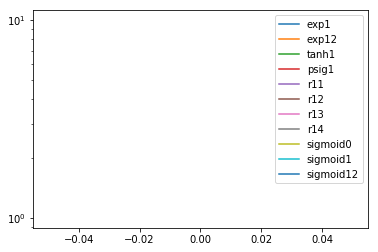

In [20]:
meth_dex = 0
wdots= np.zeros((len(eps),len(equations)))
for meth_dex in range(len(equations)):
    for ep_index,ep in enumerate(eps):
        
        param_a = np.load(f'data/{equations[meth_dex]}_1/{ep}.npy')
        param_b = np.load(f'data/{equations[-1]}_1/{ep}.npy')
        
        s1 = norm(loc=param_a.mean(),scale=param_a.std())
        r1 = s1.pdf(np.linspace(-20,20,500))
    
        s2 = norm(loc=param_b.mean(),scale=param_b.std())
        r2 = s2.pdf(np.linspace(-20,20,500))
    
        wdots[ep_index,meth_dex]= (r2*np.log(r2/r1)).sum()
plt.figure()
for i in range(len(equations)):
    plt.plot(eps,wdots[:,i],label=equations[i])
plt.legend()
plt.yscale('log')